## Chương 12: Additional Problems in Image Processing

#### __Thuật toán Seam Carving__

#### 1. Nhập các thư viện cần thiết

In [ ]:
# cv2 để xử lý ảnh và video
import cv2
# numpy để xử lý mảng và tính toán số học
import numpy as np
# os, path, glob để quản lý đường dẫn và tệp tin hệ thống
import os
import errno
from os import path
from glob import glob
# matplotlib để trực quan hóa hình ảnh
import matplotlib as mpl
import matplotlib.pyplot as plt
# time để đo lường thời gian thực thi
import time

#### 2. Định nghĩa các hàm chính của thuật toán Seam Carving

In [ ]:
# Tính toán bản đồ năng lượng của hình ảnh bằng cách sử dụng đạo hàm Sobel để nhận diện các cạnh
def calc_img_energy(image):
    image = image.astype('float32')
    # Tính đạo hàm theo trục x và y
    energy = np.absolute(cv2.Sobel(image, -1, 1, 0)) + np.absolute(cv2.Sobel(image, -1, 0, 1))
    # Tổng hợp năng lượng từ các kênh màu để có bản đồ năng lượng đơn kênh
    energy_map = np.sum(energy, axis=2)
    return energy_map

In [ ]:
# Tính toán chi phí tích lũy cho mỗi pixel và lưu lại chỉ số của pixel trước đó trong đường seam tối ưu
def calc_seam_cost_forward(energy_map):
    shape = m, n = energy_map.shape
    # Bản đồ chi phí tích lũy
    e_map = np.copy(energy_map).astype('float32')
    # Lưu lại đường đi tối ưu từ dưới lên trên
    backtrack = np.zeros(shape, dtype=int)
    # Duyệt qua từng pixel để tính chi phí tích lũy bằng cách chọn pixel có chi phí thấp nhất từ hàng trên
    for i in range(1, m):
        for j in range(0, n):
            if j == 0:
                min_idx = np.argmin(e_map[i - 1, j:j + 2])
                min_cost = e_map[i - 1, j + min_idx]
                e_map[i, j] += min_cost
                backtrack[i, j] = j + min_idx
            else:
                min_idx = np.argmin(e_map[i - 1, j - 1:j + 2])
                min_cost = e_map[i - 1, j + min_idx - 1]
                e_map[i, j] += min_cost
                backtrack[i, j] = j + min_idx - 1
    return (e_map, backtrack)

In [ ]:
# Tìm đường seam có tổng năng lượng thấp nhất bằng cách sử dụng bản đồ chi phí và bảng backtrack
def find_min_seam(energy_map_forward, backtrack):
    shape = m, n = energy_map_forward.shape
    # Mảng lưu trữ chỉ số cột của seam cho từng hàng
    seam = np.zeros(m, dtype=int)
    # Chỉ số cột với chi phí thấp nhất ở hàng cuối cùng
    idx = np.argmin(energy_map_forward[-1])
    cost = energy_map_forward[-1][idx]
    seam[-1] = idx
    # Sử dụng backtrack để xác định đường seam từ dưới lên trên
    for i in range(m - 2, -1, -1):
        idx = backtrack[i + 1, idx]
        seam[i] = idx
    return seam, cost

In [ ]:
# Hiển thị đường seam trên hình ảnh bằng cách vẽ đường đỏ tại vị trí seam
def draw_seam(image, seam):
    rows = np.arange(0, seam.shape[0], 1)
    # Tách các kênh màu
    blue, green, red = cv2.split(image)
    blue[rows, seam] = 0
    green[rows, seam] = 0
    # Đánh dẫu vị trí seam
    red[rows, seam] = 255
    img_with_seam = np.zeros((blue.shape[0], blue.shape[1], 3))
    # Ghép lại các kênh màu để tạo hình ảnh có seam được vẽ
    img_with_seam[:,:,0] = blue
    img_with_seam[:,:,1] = green
    img_with_seam[:,:,2] = red
    return img_with_seam

In [ ]:
# Loại bỏ đường seam khỏi hình ảnh, giảm một cột pixel
def remove_seam(image, seam):
    m, n, _ = image.shape
    out_image = np.zeros((m, n - 1, 3)).astype(dtype=int)
    for i in range(m):
        j = seam[i]
        # Loại bỏ pixel tại vị trí seam cho từng hàng và mỗi kênh màu
        out_image[i, :, 0] = np.delete(image[i, :, 0], j)
        out_image[i, :, 1] = np.delete(image[i, :, 1], j)
        out_image[i, :, 2] = np.delete(image[i, :, 2], j)
    return out_image

In [ ]:
# Chèn một đường seam vào hình ảnh, tăng thêm một cột pixel
# Nếu seam ở đầu hoặc cuối hàng, xử lý riêng biệt để tránh lỗi chỉ số
def insert_seam(image, seam):
    m, n, num_channels = image.shape
    out_image = np.zeros((m, n + 1, 3)).astype(dtype=int)
    for i in range(m):
        j = seam[i]
        for ch in range(num_channels):
            if j == 0:
                out_image[i, j, ch] = image[i, j, ch]
                out_image[i, j + 1:, ch] = image[i, j:, ch]
                out_image[i, j + 1, ch] = (int(image[i, j, ch]) + int(image[i, j + 1, ch])) / int(2)
            elif j + 1 == n:
                out_image[i, :j + 1, ch] = image[i, :j + 1, ch]
                out_image[i, j + 1, ch] = int(image[i, j, ch])
            else:
                out_image[i, :j, ch] = image[i, :j, ch]
                out_image[i, j + 1:, ch] = image[i, j:, ch]
                out_image[i, j, ch] = (int(image[i, j - 1, ch]) + int(image[i, j + 1, ch])) / int(2)
    return out_image

In [ ]:
# Loại bỏ một đường seam dọc từ hình ảnh
def remove_vertical_seam(image):
    img = np.copy(image)
    # Tính bản đồ năng lượng
    energy_map = calc_img_energy(img)
    # Tính chi phí và backtrack
    energy_map_forward, backtrack = calc_seam_cost_forward(energy_map)
    # Tìm seam tối ưu
    (min_seam, cost) = find_min_seam(energy_map_forward, backtrack)
    # Loại bỏ seam khỏi hình ảnh
    img = remove_seam(img, min_seam)
    return img, cost

In [ ]:
# Loại bỏ một đường seam ngang bằng cách xoay hình ảnh, loại bỏ seam dọc, sau đó xoay lại
def remove_horizontal_seam(image):
    # Xoay hình ảnh để chuyển seam ngang thành seam dọc, thực hiện loại bỏ, sau đó xoay lại
    img = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    energy_map = calc_img_energy(img)
    energy_map_forward, backtrack = calc_seam_cost_forward(energy_map)
    (min_seam, cost) = find_min_seam(energy_map_forward, backtrack)
    img = remove_seam(img, min_seam)
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return img, cost

#### 3. Xử lý hình ảnh và thực hiện Seam Carving

Figure Shape: (960, 1280, 3)


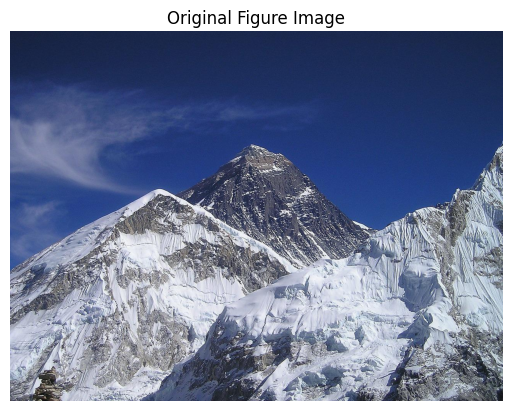

In [25]:
# Đọc hình ảnh từ đường dẫn, chuyển đổi từ định dạng BGR sang RGB để đúng màu khi hiển thị với Matplotlib
# Đọc hình ảnh màu
fig = cv2.imread('../images/hill.jpg', cv2.IMREAD_COLOR)
# Chuyển đổi không gian màu
rgb_fig = cv2.cvtColor(fig, cv2.COLOR_BGR2RGB)
# Hiển thị hình ảnh
plt.imshow(rgb_fig); 
plt.axis("off"); 
plt.title("Original Figure Image");
# In kích thước hình ảnh (chiều cao, chiều rộng, kênh màu)
print("Figure Shape: %s" % (fig.shape,))

In [26]:
# Loại bỏ 350 đường seam dọc từ hình ảnh, giảm kích thước theo chiều rộng
# Bắt đầu đo thời gian thực thi
t0 = time.time()
# Lấy đường dẫn hiện tại
path = os.path.join(os.getcwd())
img = np.copy(fig)
# Vòng lặp 350 lần
for c in range(350):
    # Tính bản đồ năng lượng
    energy_map = calc_img_energy(img)
    # Tính chi phí và backtrack
    energy_map_forward, backtrack = calc_seam_cost_forward(energy_map)
    # Tìm seam tối ưu
    (min_seam, cost) = find_min_seam(energy_map_forward, backtrack)
    # Vẽ seam lên hình ảnh và lưu lại hình ảnh có seam
    bgr_img_with_seam = draw_seam(img, min_seam)
    cv2.imwrite('%s%s.png' % (path, c), bgr_img_with_seam)
    # Loại bỏ seam khỏi hình ảnh
    img = remove_seam(img, min_seam)
# Lưu lại hình ảnh sau khi đã loại bỏ tất cả seam
cv2.imwrite('%ssea_resized.jpg' % (path), img)
# Tính toán tổng thời gian thực thi
t1 = time.time()
total = t1-t0
print("Total Time: %d" % total)

Total Time: 2311


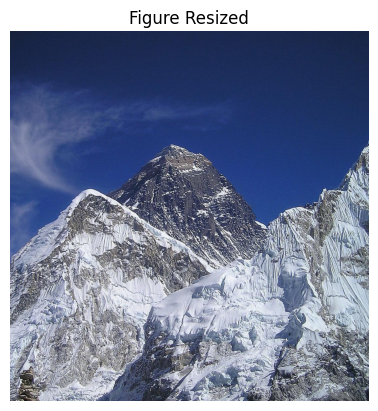

In [ ]:
# Hiển thị hình ảnh sau khi đã loại bỏ 350 seam, giảm kích thước theo chiều rộng
# Tách các kênh màu
blue, green, red = cv2.split(img)
# Ghép lại các kênh màu theo thứ tự RGB
rgb_img = np.dstack([red, green, blue])
# Hiển thị hình ảnh đã được chèn seam
plt.imshow(rgb_img); 
plt.axis("off"); 
plt.title("Figure Resized");
plt.savefig('hill_resized.png')